In [119]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import requests
import urllib.request
from bs4 import BeautifulSoup
import bleach
import re
import matplotlib.pyplot as plt
%matplotlib inline
from fa2 import ForceAtlas2
import pickle
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [20]:
def printList(lst):
    count = 0
    for i in lst:
        print(i)
        count += 1
        if count == 5:
            break
    return 
def printDic(dic):
    count = 0
    for (k,v) in dic.items():
        print(k , v)
        count += 1
        if count == 5:
            break
    return

## Data Extraction

There are two tables listing main characters in wikipedia page. We will conduct network analysis on these charactors.

Source : https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters.

In [3]:
table1=pd.read_csv("table-1.csv")
table2=pd.read_csv("table-2.csv")

In [11]:
list1=table1.Character.tolist()[1:]
list2=table2.Character.tolist()[1:]
list_full=list1 + list2
printList(list_full)

Eddard Stark
Robert Baratheon
Jaime Lannister
Catelyn Stark
Cersei Lannister


**We will use web scraping to extract data**

In [130]:
def getText():
    
    pages_dic={}
    
    for character in list_full:
    
        # parse url character name
        if " " in character:
            character = re.sub(r" ", "_", character)

        url="https://gameofthrones.fandom.com/wiki/" + character # get base url

        response = requests.get(url) # request a server response

        # not found
        if response.status_code == 404:
            print("{} wiki is not found.".format(character))
            continue

        soup = BeautifulSoup(response.text, "html.parser") # parse text from html

        para=soup.findAll('p') # find all paragraphs

        # clean the raw text
        res=[]
        for p in para:
            p = re.sub(r"<.+?>", "", str(p)) # remove all other tags e.g. <a href>
            p = re.sub(r"\[\d+?\]", " ", p)  # remove footnote label e.g. [1], [2]
            p = re.sub(r"\n", "", p)         # remove the nextline character
            p = re.sub(r"\xa0", u" ", p)     # remove empty space due to encoding

            if len(p) != 0 and p[-1] == " ": # remove empty space at the end, if present
                p = p[:-1]
            res.append(p)

        page="".join(res)
        
        pages_dic[character] = page
    
    # save the file
    pickle.dump(pages_dic, open('pages.p', 'wb'))
    return None

In [62]:
# only run once
# getText()

The_High_Sparrow wiki is not found.
Grand_Maester_Pycelle wiki is not found.
Maester_Wolkan wiki is not found.
Khal_Moro wiki is not found.
Archmaester_Ebrose wiki is not found.


In [5]:
infile = open("pages.p",'rb')
pages = pickle.load(infile)
infile.close()

> Build a network of main charactors.

* Node is charactor name
* Edge is their connection identified in wiki page

However, each character may have many nicknames/alias. In order to achieve higher accuracy, we find out all possible nicknames/alias (tried my best and it is tedious). We build a dictionary with key = Full Name and value = list of nicknames. We only consider nicknames for characters who are featured in https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki.

In [12]:
def characterDic():
    nicknames={}
    
    for name in pages.keys():
        parsed_name = name.replace("_", " ")
        nicknames[parsed_name] = [parsed_name,]
    
        # special cases --> not really literal names     
        if parsed_name in ["High Septon", "Black Walder Rivers", "Spice King",
                           "Night King", "Wun Weg Wun Dar Wun", "Lady Crane",
                           "Grey Worm", "Silk King","Little Sam","Hot Pie",
                           "Khal Drogo","Three-Eyed Raven","Black Lorren",
                           "Maester Luwin", "Maester Aemon","The Waif"]:
            continue
                  
        # general case --> extract first name
        if " " in parsed_name:
            firstname = parsed_name.split(" ")[0]
            nicknames[parsed_name] += [firstname,]
    
    # Some manual editing to improve accuracy
    nicknames["Jon Snow"] += ["Aegon", "Lord Snow"]
    nicknames["Bran Stark"] += ["Three-Eyed Raven", "Brandon"]
    nicknames["Davos Seaworth"] += ["Onion Knight", "Davos"]
    nicknames["Jaime Lannister"] += ["Kingslayer"]
    nicknames["Tyrion Lannister"] += ["Imp", "Halfman", "Little Lion"]
    nicknames["Gregor Clegane"] += ["The Mountain",]
    nicknames["Joffrey Baratheon"] += ["Joff"]
    nicknames["Daenerys Targaryen"] += ["Daenerys Stormborn", "Stormborn", "Dany", 
                                       "Mhysa", "Dragon Queen", "Khaleesi"]
    nicknames["Varys"] += ["Spider", "Eunuch"]
    nicknames["Theon Greyjoy"] += ["Reek",]
    nicknames["Grey Worm"] += ["Torgo Nudho",]
    nicknames["Olenna Tyrell"] += ["Redwyne",]
    nicknames["Brienne of Tarth"] += ["Brienne", "Maid of Tarth"]
    nicknames["Samwell Tarly"] += ["Sam", "Piggy"]
    nicknames["Gendry Baratheon"] = ["Gendry", "Clovis"]
    nicknames["Petyr Baelish"] += ["Littlefinger", "Baelish"]
    nicknames["Sandor Clegane"] += ["Hound"]
    nicknames["Melisandre"] += ["Red Woman", "Red Witch"]
    
    return nicknames

In [21]:
characters=characterDic()
printDic(characters)

Eddard Stark ['Eddard Stark', 'Eddard']
Robert Baratheon ['Robert Baratheon', 'Robert']
Jaime Lannister ['Jaime Lannister', 'Jaime', 'Kingslayer']
Catelyn Stark ['Catelyn Stark', 'Catelyn']
Cersei Lannister ['Cersei Lannister', 'Cersei']


In [22]:
def edgeWeight():
    # key = (A,B), value = N
    # In wiki page of A, B is mentioned N times
    res_dic={}
    
    # loop through each character
    for ch in characters:
        
        # obtain all his names/alias
        alias=characters[ch]
        
        # loop through every wikipages
        for name in pages:
                
            parsed_name = name.replace("_", " ")
            
            # obtain the text
            text=pages[name] 
            
            # prevent self loop --> Jon Snow page mentions Jon Snow himself N times
            if parsed_name != ch:
                for al in alias:
                    text=text.replace(al, ch)
                
                count=text.count(ch)
                    
                # update result dictionary
                if count != 0:
                    res_dic[(parsed_name, ch)]=count

    return res_dic

In [23]:
edgeWightDic=edgeWeight()
printDic(edgeWightDic)

('Robert Baratheon', 'Eddard Stark') 43
('Jaime Lannister', 'Eddard Stark') 26
('Catelyn Stark', 'Eddard Stark') 29
('Cersei Lannister', 'Eddard Stark') 30
('Daenerys Targaryen', 'Eddard Stark') 5


In [24]:
G=nx.DiGraph()
G.add_nodes_from(characters.keys())
G.add_edges_from([(k[0],k[1],{"weight" : v}) for (k,v) in edgeWightDic.items()])

In [28]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)
positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), 
                                                    pos=None,iterations=10000)

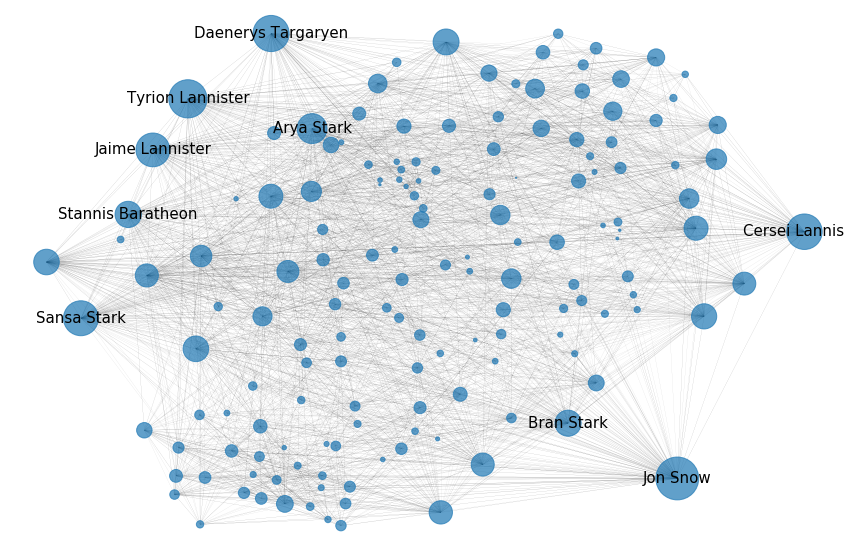

In [29]:
labeling={}
for node in G.nodes:
    if G.degree(weight="weight")[node] > 1500:
        labeling[node] = node
nodeSize=[G.degree(weight="weight")[character] for character in G.nodes]      

plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.3, arrows=False)
nx.draw_networkx_nodes(G, positions,alpha= 0.7, 
                       node_size=[size/sum(nodeSize) * 100000/3 for size in nodeSize])
nx.draw_networkx_labels(G, positions, labels=labeling, font_size=15)
plt.show()

Some helper function before giving our awards.

In [33]:
# get color list --> different colors for top 3 characters
def getColorList(champion, first_runner_up, second_runner_up):
    colorList=[]
    for node in G.nodes:
        if node == champion:
            colorList.append("#ffd700") # gold
        elif node == first_runner_up:
            colorList.append("#aaa9ad") # silver
        elif node == second_runner_up:
            colorList.append("#cd7f32") # bronze
        else:
            colorList.append("#add8e6")
    return colorList

In [34]:
# get label list --> label for top N charaters
def getLabeling(sortedList, topN):
    labeling={}
    for node in G.nodes:
        if node in list(map(lambda x : x[0], sortedList[:topN])):
            labeling[node] = node
    return labeling

In [35]:
# general plot function
def plot(sizes,colors, labeling, adjustFactor): # adjustFactor to control node size
    plt.figure(figsize=(15,10))
    plt.axis("off")
    nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.3, arrows=False)
    nx.draw_networkx_nodes(G, positions,alpha= 0.7, node_color=colors,
                           node_size=[size * adjustFactor for size in sizes])
    nx.draw_networkx_labels(G, positions, labels=labeling, font_size=12)
    plt.show()
    return 

> ## Most Mentioned Award

Who is mentioned the most number of times in others' wiki page?

In [36]:
sorting=sorted(list(G.in_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 2881), ('Daenerys Targaryen', 2030), ('Tyrion Lannister', 1990)]

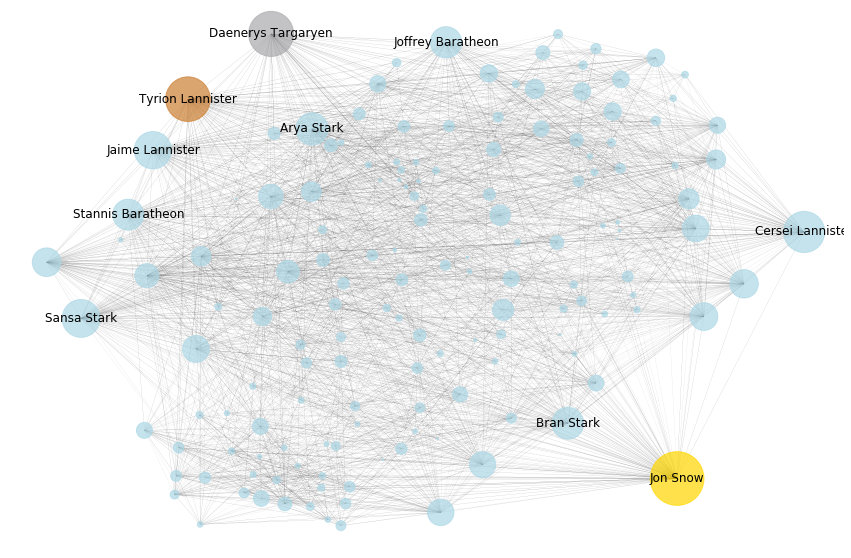

In [37]:
plot([G.in_degree(weight="weight")[character] for character in G.nodes],
     getColorList('Jon Snow','Daenerys Targaryen','Tyrion Lannister'),
     getLabeling(sorting, 10),1)

## The most mentioned award goes to........Jon Snow!

> ## Most Social Award

Whose page mentioned the most number of other characters?

In [38]:
sorting=sorted(list(G.out_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Sansa Stark', 1270), ('Tyrion Lannister', 1243), ('Jon Snow', 1183)]

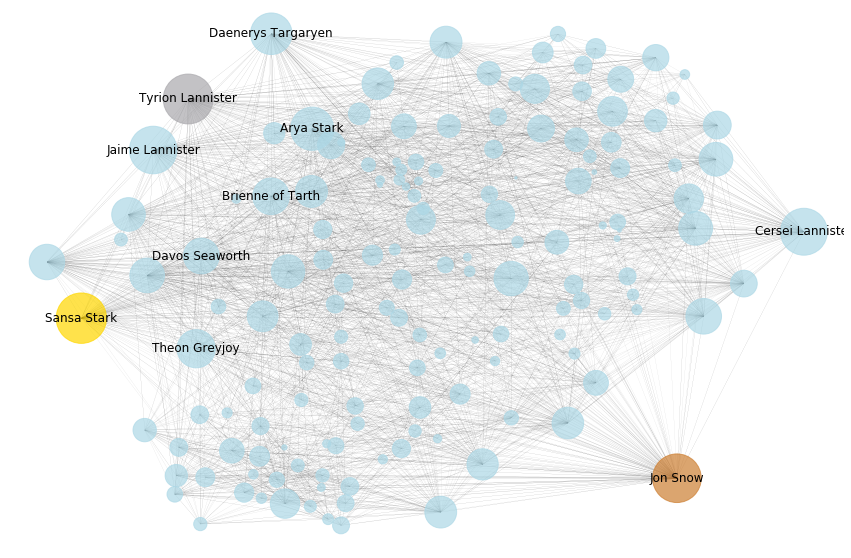

In [41]:
plot([G.out_degree(weight="weight")[character] for character in G.nodes],
     getColorList('Sansa Stark','Tyrion Lannister', 'Jon Snow'),
     getLabeling(sorting, 10), 2)

## The most social award goes to........Sansa Stark!

> ## Most "Reachable" Award

Who is on average closest other characters, starting from all the other nodes?

In [42]:
sorting=sorted(list(nx.closeness_centrality(G).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.7677095631641087),
 ('Tyrion Lannister', 0.6909386068476978),
 ('Cersei Lannister', 0.6816434686389844)]

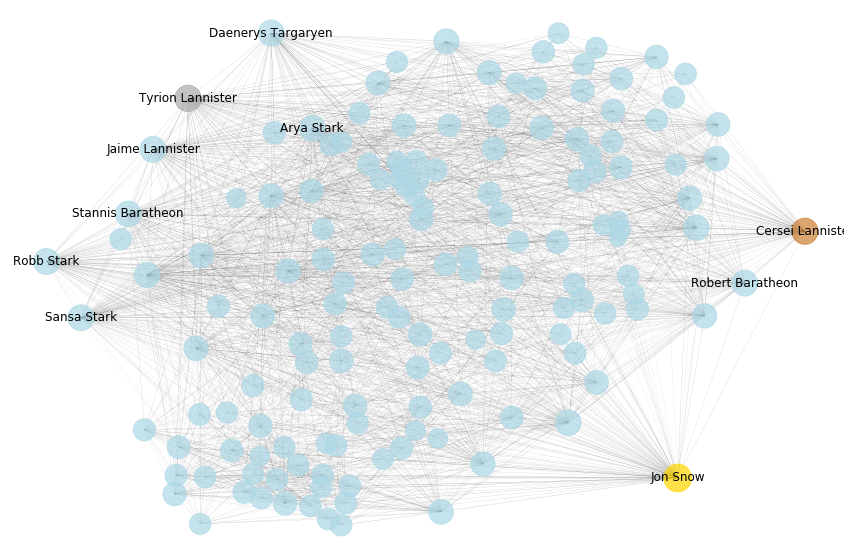

In [45]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Tyrion Lannister','Cersei Lannister'),
     getLabeling(sorting, 10), 1000)

## The most "reachable" award goes to........Jon Snow!

> ## The Delivery-Man Award

Who is on average closest other characters, starting from the node to other nodes? i.e. If I want to deliver pizza to every character. One character is chosen to be the starting point. Who will be the chosen character such that the time taken to spread message is minimized?

In [46]:
sorting=sorted(list(nx.closeness_centrality(G.reverse()).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.6609073745637623),
 ('Tyrion Lannister', 0.627723740694452),
 ('Jaime Lannister', 0.6225144150455354)]

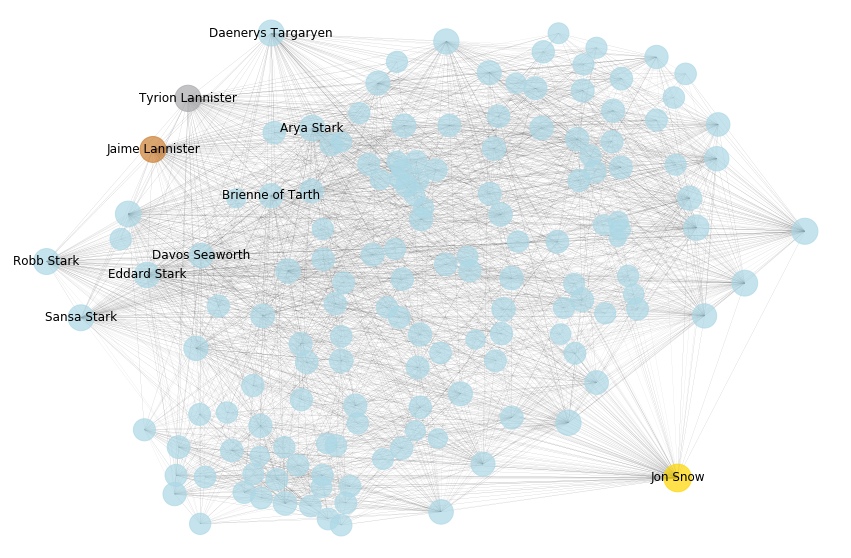

In [48]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Tyrion Lannister','Jaime Lannister'),
     getLabeling(sorting, 10), 1000)

## The Delivery-Man award goes to........Jon Snow!

> ## Most Critical Award 

Who appears the most number of times in the shortest path between any other two nodes?

In [49]:
sorting=sorted(list(nx.betweenness_centrality(G.reverse()).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.10258812592928719),
 ('Daenerys Targaryen', 0.08495488238473345),
 ('Arya Stark', 0.07439741540442442)]

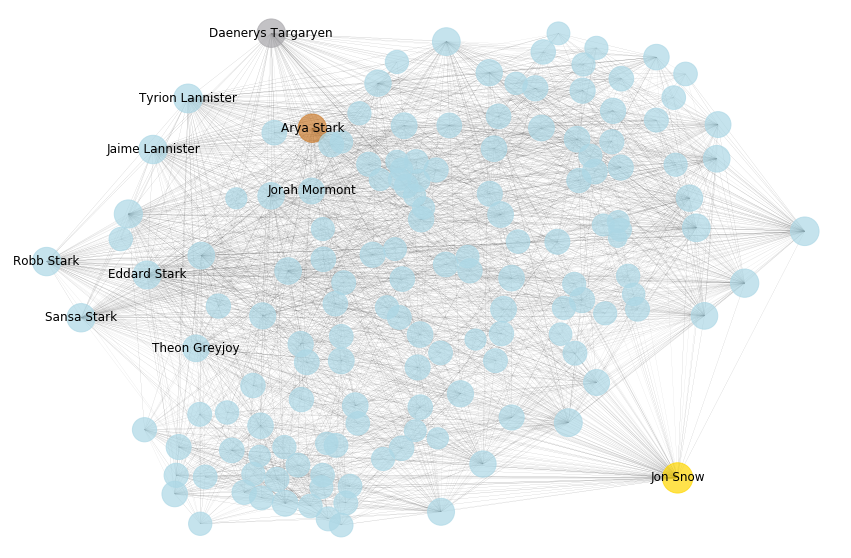

In [51]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Daenerys Targaryen','Arya Stark'),
     getLabeling(sorting, 10), 1200)

## The most critical award goes to........Jon Snow!

> ## Person with the most powerful connections

Who has the most powerful people as his connections? i.e. good if friends, bad if enemies!

In [52]:
sorting=sorted(list(nx.eigenvector_centrality(G).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.20908603915428334),
 ('Cersei Lannister', 0.19097230878131516),
 ('Tyrion Lannister', 0.19014705946358837)]

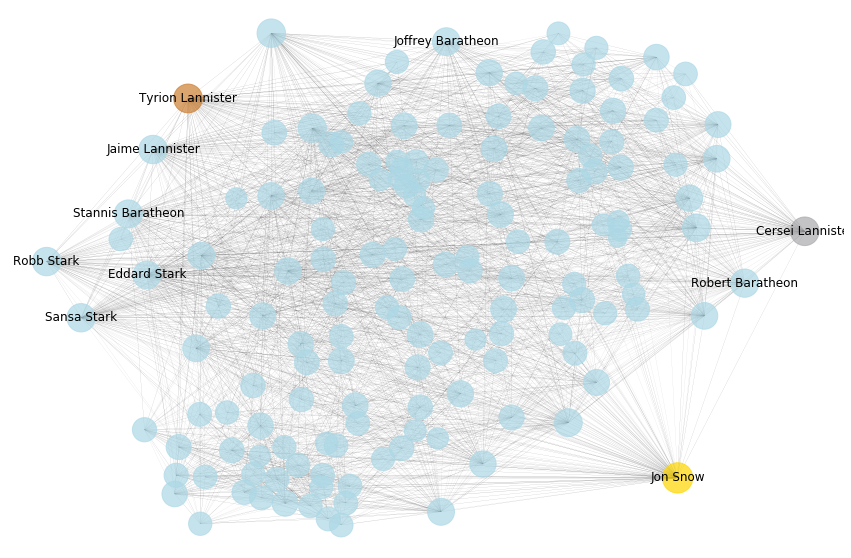

In [54]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Cersei Lannister','Tyrion Lannister'),
     getLabeling(sorting, 10), 1200)

## The award goes to........Jon Snow!

# Word Cloud && TF-IDF

In [146]:
def getNames():
    lst=[]
    for (k,v) in characters.items():
        lst.append(k.lower())
        lst.extend([vi.lower() for vi in v])
    return lst
nameList=getNames()

In [150]:
def keyWords(character, topN, excludeNames=False):
    page=pages[character].lower()
    
    if excludeNames:
        for name in nameList:
            page = page.replace(name, "")
    
    sentences=page.split(".")
    
    # init a count vector
    count_vector=CountVectorizer(max_df=0.9,stop_words="english")

    # create a word count for sentences
    word_count_vector=count_vector.fit_transform(sentences)
    
    # init a tfidf transformer
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    
    # fit with the word count vector
    tfidf_transformer.fit(word_count_vector)
    
    # sub our interested doc into the transformer
    tf_idf_vector=tfidf_transformer.transform(count_vector.transform([page]))
    
    # get the key words
    feature_names=count_vector.get_feature_names()
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,topN)
    
    return keywords

In [151]:
keyWords('Cersei_Lannister', 3, True)

{'king': 0.2, 'tells': 0.169, 'children': 0.131}

In [78]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn):
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a dictionary of feature,score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [160]:
def wordCloud(character, number_words=100, excludeName=False):
    plt.figure(figsize=(12,6))
    word_cloud = WordCloud(background_color="white", width=1500, height=800, 
                        max_words = number_words, colormap = 'Blues')
    word_cloud.generate_from_frequencies(
        keyWords(character, number_words, excludeName))

    plt.imshow(word_cloud, interpolation="bilinear")
    plt.title("{} WordCloud".format(character.replace("_", " ")), y=1.05)
    plt.axis("off")
    plt.show()
    return

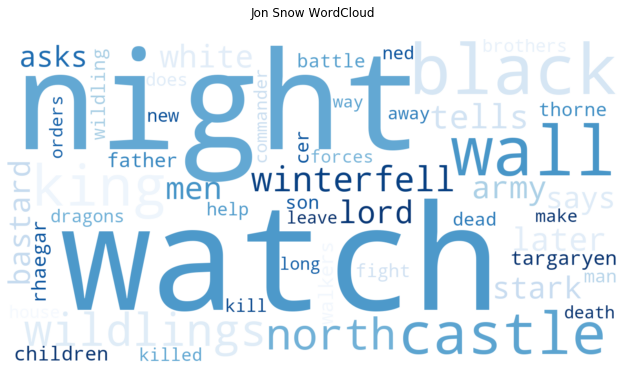

In [161]:
wordCloud("Jon_Snow", 50, excludeName=True)